# Collaboration and Competition

---

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


![Tennis](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/images/tennis.png?raw=true)

* Set-up: Two-player game where agents control rackets to bounce ball over a
  net.
* Goal: The agents must bounce ball between one another while not dropping or
  sending ball out of bounds.
* Agents: The environment contains two agent linked to a single Brain.
* Agent Reward Function (independent):
  * +0.1 To agent when hitting ball over net.
  * -0.01 To agent who let ball hit their ground, or hit ball out of bounds.
* Brains: One Brain with the following observation/action space.
  * Vector Observation space: 8 variables corresponding to position and velocity
    of ball and racket.
  * Vector Action space: (Continuous) Size of 2, corresponding to movement
    toward net or away from net, and jumping.
* Reset Parameters: Three
    * angle: Angle of the racket from the vertical (Y) axis.
      * Default: 55
      * Recommended Minimum: 35 
      * Recommended Maximum: 65
    * gravity: Magnitude of gravity
      * Default: 9.81
      * Recommended Minimum: 6
      * Recommended Maximum: 20
    * scale: Specifies the scale of the ball in the 3 dimensions (equal across the three dimensions)
      * Default: 1
      * Recommended Minimum: 0.2
      * Recommended Maximum: 5
* Benchmark Mean Reward: 0.5

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

**Note:** you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. Train the agents

The Multi-Agent Deep Deterministic Policy Gradient(MA-DDPG) can be trained by calling the ma_ddpg function defined bellow. Both agent and model classes are invoked from their respective helper files.

**Note:** When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
from ma_ddpg_agent import Agent
import random
import torch
from collections import deque
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
# initialize the agents
agent1 = Agent(num_agents=1, state_size=state_size, action_size=action_size, random_seed=0)
agent2 = Agent(num_agents=1, state_size=state_size, action_size=action_size, random_seed=0)

### Multi-Agent Deep Deterministic Policy Gradient(MA-DDPG)

This solution makes use of the approach presented in the paper "Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments". We use Actor-Critic networks, same as Deep deterministic policy gradients post, but instead of training each agent to learn from its own action, we incorporate actions taken by all agents. Why use actions taken by all agents to train the single agent? Because, the environment state depends on the actions taken by all agents (i.e non-stationary from a single agent's perspective) so if we just train the agent using its own action, the policy network does not get enough information to come up with a good policy and most likely will take longer to find any good policy.

![MA-DDPG Algorithm](https://miro.medium.com/max/747/1*sfPu94LSl9nSKkvGIx-msw.png)

Going back to Multi-Agent Actor-Critic paper, the action from each agent is used only during the training phase to ease the training (centralised training). During execution, we just use the the policy network that returns the action for a given state. We do not use any information from other agents (i.e. decentralised execution).

![Training Phase](https://www.katnoria.com/static/f2e485d3a562562c8ce6600e4c930ef6/02ec2/maddpg_overview.png)

This approach builds upon Deep Deterministic Policy Gradients(DDPG) and Deep Q-Network(DQN), so it is best to review some of the core concepts such as experience replay, fixed target network and actior-critic there. We will go over them rather quickly here.

- The Actor network takes state as input and returns the action to take in the environment
- The Critic network, Deep Q-Network, takes the state and action of all agents as input and returns the action-value (Q-value)
- The Critic and Actor networks are trained by sampling experiences from the replay buffer.
- The action-value from Critic is used to teach the Actor to choose better actions.

The key improvement over the DDPG approach is that we now share the actions taken by all agents to train each agent.

#### Network Architecture

![Network Achitecture](https://www.katnoria.com/static/91ab09cf86f38ac97ebd3279cf47c618/5593c/ma_ddpg_architecture.png)

Credits to Katnoria - "Continuos Control With Deep Reinforcement Learning"

#### Hyperparemeters

I tried several hyperparameters in order to solve the environment and the following worked the best for me.

    - BUFFER_SIZE = int(1e6)      replay buffer size
    - BATCH_SIZE = 128            minibatch size
    - GAMMA = 0.99                discount factor
    - TAU = 8e-2                  for soft update of target parameters
    - LR_ACTOR = 1e-3             learning rate of the actor 
    - LR_CRITIC = 1e-3            learning rate of the critic
    - WEIGHT_DECAY = 0            L2 weight decay
    - UPDATE_EVERY = 1            how often to update the network
    - UPDATE_NUM = 2              number of update passes
    - EPSILON_START = 5.0         starting value of epsilon(noise decay process)
    - EPSILON_END = 300           episode number to end the noise decay process
    - EPSILON_THRESHOLD = 0       threshold value for epsilon

In [9]:
def ma_ddpg(n_episodes=2000, max_timestep=1000, print_every=10, score_goal=0.5, limit_episodes=300,
            agent1_actor_path='agent1_actor_checkpoint.pth', agent1_critic_path='agent1_critic_checkpoint.pth',
            agent2_actor_path='agent2_actor_checkpoint.pth', agent2_critic_path='agent2_critic_checkpoint.pth'):
    """Multi-Agent Deep Deterministic Policy Gradient (MA-DDPG)

    Params
    ======
        n_episodes (int)         : maximum number of training episodes
        max_timestep (int)       : maximum number of timesteps per episode
        print_every (int)        : print results every print_every number of episodes
        score_goal (float)       : average reward over the last 100 episodes to solve environment
        limit_episodes (int)     : stop training after limit_episodes without converging
        agent1_actor_path (str)  : directory to store agent 1 actor network weights
        agent1_critic_path (str) : directory to store agent 1 critic network weights
        agent2_actor_path (str)  : directory to store agent 2 actor network weights
        agent2_critic_path (str) : directory to store agent 2 critic network weights

    """
    all_scores = []                      # initialize list for the mean scores from each episode
    moving_avgs = []                     # initialize list for the moving averages of the episodes
    scores_window = deque(maxlen=100)    # initialize a container for the mean scores of the last 100 episodes
    best_score = -np.inf
    best_episode = 0
    solved = False
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]   # reset the environment
        # get the current states and combine them
        states = np.reshape(env_info.vector_observations, (1, state_size*num_agents))
        scores = np.zeros(num_agents)                       # initialize the score (for each agent)
        agent1.reset()
        agent2.reset()
        while True:
            # get actions for each agent and combine them (add_noise=True)
            actions = np.concatenate((agent1.act(states), agent2.act(states)), axis=0).flatten()
            env_info = env.step(actions)[brain_name]        # send actions to environment
            # get next state (for each agent)
            next_states = np.reshape(env_info.vector_observations, (1, state_size*num_agents))
            rewards = env_info.rewards                      # get reward (for each agent)
            done = env_info.local_done                      # see if episode finished
            # learning step for each agent
            agent1.step(states, actions, rewards[0], next_states, done, 0)
            agent2.step(states, actions, rewards[1], next_states, done, 1)
            # save experience to replay buffer and perform learning step at defined interval
            scores += np.max(rewards)                       # update the score (for each agent)
            states = next_states                            # roll over states to next time step
            if np.any(done):                                # exit loop if episode finished
                break
                
        episode_best_score = np.max(scores)                 # select best score from the episode
        scores_window.append(episode_best_score)            # save best score from the episode(100 best scores)
        all_scores.append(episode_best_score)               # save best score from the episode
        moving_avgs.append(np.mean(scores_window))          # save moving average
        
        # save best score                        
        if episode_best_score > best_score:
            best_score = episode_best_score
            best_episode = i_episode
            
        # print results every print_every episodes
        if i_episode % print_every == 0:
            print('\rEpisode {} : Moving Average - {:.2f} | Min score - {:.2f} | Max score - {:.2f}'
                  .format(i_episode, moving_avgs[-1],
                          np.min(all_scores[-print_every:]), np.max(all_scores[-print_every:])))
        
        # check if environment is solved and save best models
        if moving_avgs[-1] >= score_goal and i_episode >= 100:
            if not solved:
                print('\rEnvironment solved in {} : Moving Average - {:.2f} | Min score - {:.2f} | Max score - {:.2f}\n'
                      .format(i_episode-100, moving_avgs[-1],
                              np.min(all_scores[-print_every:]), np.max(all_scores[-print_every:])))
                solved = True
                # save weights for the models when environment is solved
                torch.save(agent1.actor_local.state_dict(), agent1_actor_path)
                torch.save(agent1.critic_local.state_dict(), agent1_critic_path)
                torch.save(agent2.actor_local.state_dict(), agent2_actor_path)
                torch.save(agent2.critic_local.state_dict(), agent2_critic_path)
            elif episode_best_score >= best_score:
                print('\rBest episode so far {} : Moving Average - {:.2f} | Best score - {:.2f}\n'
                      .format(i_episode, moving_avgs[-1], episode_best_score))
                # save weights for the models if score improves
                torch.save(agent1.actor_local.state_dict(), agent1_actor_path)
                torch.save(agent1.critic_local.state_dict(), agent1_critic_path)
                torch.save(agent2.actor_local.state_dict(), agent2_actor_path)
                torch.save(agent2.critic_local.state_dict(), agent2_critic_path)
            elif (i_episode-best_episode) >= limit_episodes:
                # stop training if the model stops converging
                print('##### TRAINING STOPPED #####\nBest score not matched or exceeded for {} episodes'
                      .format(limit_episodes))
                break
            else:
                continue
                
    return all_scores, moving_avgs

In [10]:
from workspace_utils import active_session

with active_session():  # used to keep Udacity's workspace awake during training
    # train the agents
    scores, moving_avgs = ma_ddpg()

Episode 10 : Moving Average - 0.00 | Min score - 0.00 | Max score - 0.00
Episode 20 : Moving Average - 0.02 | Min score - 0.00 | Max score - 0.10
Episode 30 : Moving Average - 0.01 | Min score - 0.00 | Max score - 0.00
Episode 40 : Moving Average - 0.02 | Min score - 0.00 | Max score - 0.10
Episode 50 : Moving Average - 0.01 | Min score - 0.00 | Max score - 0.10
Episode 60 : Moving Average - 0.01 | Min score - 0.00 | Max score - 0.00
Episode 70 : Moving Average - 0.02 | Min score - 0.00 | Max score - 0.20
Episode 80 : Moving Average - 0.02 | Min score - 0.00 | Max score - 0.10
Episode 90 : Moving Average - 0.02 | Min score - 0.00 | Max score - 0.20
Episode 100 : Moving Average - 0.02 | Min score - 0.00 | Max score - 0.20
Episode 110 : Moving Average - 0.02 | Min score - 0.00 | Max score - 0.10
Episode 120 : Moving Average - 0.03 | Min score - 0.00 | Max score - 0.20
Episode 130 : Moving Average - 0.03 | Min score - 0.00 | Max score - 0.20
Episode 140 : Moving Average - 0.03 | Min score

#### The environment is considered solved when the average reward over 100 episode is +0.5.

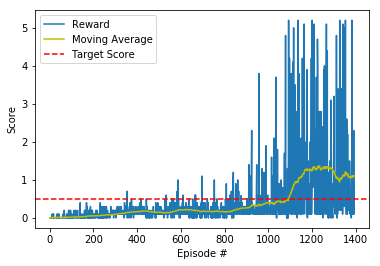

In [13]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(np.arange(len(scores)), scores, label='Reward')
plt.plot(np.arange(len(scores)), moving_avgs, color='y', label='Moving Average')
plt.axhline(0.5, color="r", linestyle='dashed', label='Target Score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

When finished, you can close the environment.

In [14]:
env.close()